<a href="https://www.kaggle.com/code/kasperlindmark/xgb-kedneystones?scriptVersionId=126282988" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
train_df.head(2)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0


In [3]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
test_df.head(2)

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46


In [4]:
train_df = train_df.drop('id', axis=1)
train_df.head(2)

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0


## Feature correlation

<AxesSubplot:>

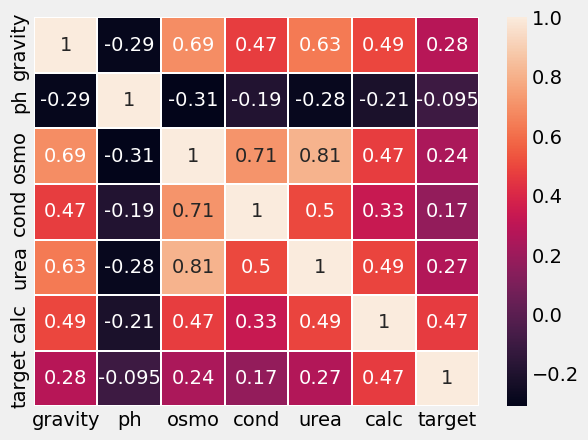

In [5]:
sns.heatmap(train_df.corr(), linewidths=0.1, annot=True, cmap="rocket")

## KDE

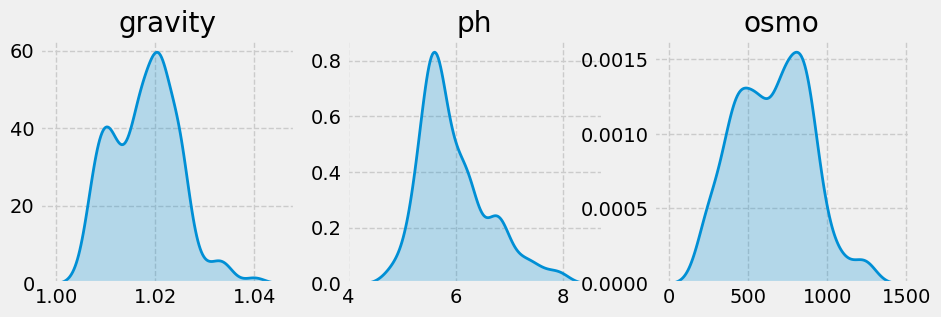

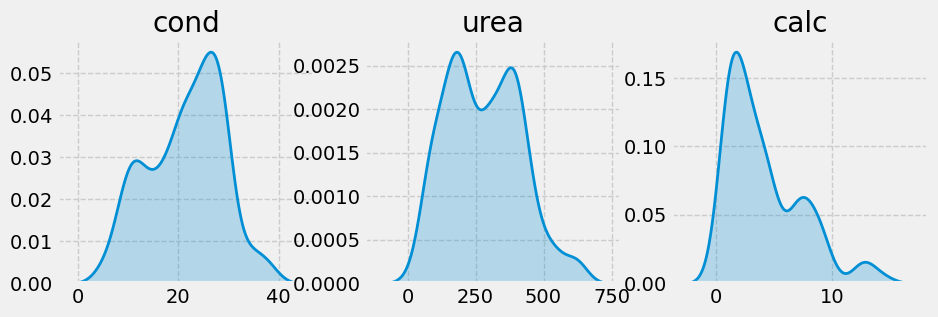

In [6]:
cols = train_df.drop('target', axis=1).columns
for name_id in range(0, len(cols), 3):
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False, sharex=False)

    sns.kdeplot(
        train_df,
        x=cols[name_id],
        ax=axes[0],
        linewidth=2,
        fill=True
    )
    axes[0].set_title(cols[name_id] )

    sns.kdeplot(
        train_df,
        x=cols[name_id + 1],
        ax=axes[1],
        linewidth=2,
        fill=True
    )
    axes[1].set_title(cols[name_id + 1])

    
    sns.kdeplot(
        train_df,
        x=cols[name_id + 2],
        ax=axes[2],
        linewidth=2,
        fill=True
    )
    axes[2].set_title(cols[name_id + 2])
    
    for ax in axes:
        ax.grid(True, which='both', linestyle='--')
        ax.set(xlabel='', ylabel='')

# Training

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

In [8]:
FEATURES_f = ['gravity','ph','osmo','cond','urea','calc']
FEATURES = FEATURES_f.copy()
def create_features (df):
    for ft in FEATURES_f:
        new_feature = ft+"_sq"
        df[new_feature] = df[ft]**2
        FEATURES.append(new_feature) if new_feature not in FEATURES else FEATURES
create_features(train_df)

TARGET = ['target']

X = train_df.drop(columns=['target'])
y = train_df['target']

In [9]:
train_df

,gravity,ph,osmo,cond,urea,calc,target,gravity_sq,ph_sq,osmo_sq,cond_sq,urea_sq,calc_sq
0,1.013,6.19,443,14.8,124,1.45,0,1.026169,38.3161,196249,219.04,15376,2.1025
1,1.025,5.40,703,23.6,394,4.18,0,1.050625,29.1600,494209,556.96,155236,17.4724
2,1.009,6.13,371,24.5,159,9.04,0,1.018081,37.5769,137641,600.25,25281,81.7216
3,1.021,4.91,442,20.8,398,6.63,1,1.042441,24.1081,195364,432.64,158404,43.9569
4,1.021,5.53,874,17.8,385,2.21,1,1.042441,30.5809,763876,316.84,148225,4.8841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1.011,5.21,527,21.4,75,1.53,0,1.022121,27.1441,277729,457.96,5625,2.3409
410,1.024,5.53,577,19.7,224,0.77,0,1.048576,30.5809,332929,388.09,50176,0.5929
411,1.018,6.28,455,22.2,270,7.68,1,1.036324,39.4384,207025,492.84,72900,58.9824
412,1.008,7.12,325,12.6,75,1.03,1,1.016064,50.6944,105625,158.76,5625,1.0609


In [10]:
params = {
    'n_estimators': 300,
    'max_depth': 2,
    'learning_rate': 0.007,
    'colsample_bylevel': 0.71, 
    'sampling_method': 'gradient_based',
    'grow_policy': 'depthwise',
    'subsample':  0.1
}

kf = KFold(n_splits=15, shuffle=True) # Define KFold with 15 folds and shuffle

mse_scores = [] # List to store mean squared error scores

for fold, (train_idx, test_idx) in enumerate(kf.split(train_df[FEATURES], train_df[TARGET])): # For each fold
    
    print(10*"=", f"Fold = {fold+1}", 10*"=")
    
    # Split data into training and test sets
    X_train, X_test = train_df.iloc[train_idx][FEATURES], train_df.iloc[test_idx][FEATURES]
    y_train, y_test = train_df[TARGET].iloc[train_idx], train_df[TARGET].iloc[test_idx]
    
    # Train linear regression model on training set. Classifier was not as precise
    reg = xgb.XGBRegressor(
        tree_method="gpu_hist", 
        objective='reg:logistic', 
        eval_metric='rmse', 
        booster='dart',
        verbosity=1,
        **params
    )
    reg.fit(X_train, y_train)
    
    # Predict output on test set
    y_pred = reg.predict(X_test)
    
    # Calculate mean squared error score and append to list
    mse_score = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse_score)
    
    print(f"Fold = {fold+1}, mse_score: {mse_score:.10f}")

# Calculate average mean squared error score
average_mse_score = sum(mse_scores) / len(mse_scores)

print("average_mse_score:  ", average_mse_score)

========== Fold = 1 ==========
Fold = 1, mse_score: 0.1584347136
========== Fold = 2 ==========
Fold = 2, mse_score: 0.1323693158
========== Fold = 3 ==========
Fold = 3, mse_score: 0.1737748409
========== Fold = 4 ==========
Fold = 4, mse_score: 0.1742733719
========== Fold = 5 ==========
Fold = 5, mse_score: 0.2072159903
========== Fold = 6 ==========
Fold = 6, mse_score: 0.1591772834
========== Fold = 7 ==========
Fold = 7, mse_score: 0.1331696393
========== Fold = 8 ==========
Fold = 8, mse_score: 0.1833651366
========== Fold = 9 ==========
Fold = 9, mse_score: 0.1744194980
========== Fold = 10 ==========
Fold = 10, mse_score: 0.2341764943
========== Fold = 11 ==========
Fold = 11, mse_score: 0.1965193589
========== Fold = 12 ==========
Fold = 12, mse_score: 0.1800327589
========== Fold = 13 ==========
Fold = 13, mse_score: 0.2029893991
========== Fold = 14 ==========
Fold = 14, mse_score: 0.1828437128
========== Fold = 15 ==========
Fold = 15, mse_score: 0.2083236481
average_mse_s

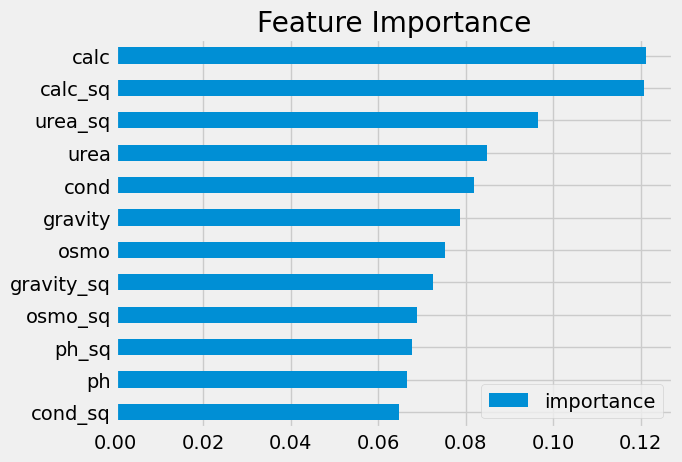

In [11]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

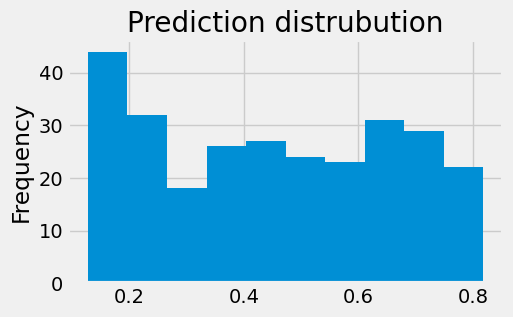

In [12]:
create_features(test_df)
X_test = test_df[FEATURES]
test_df['target'] = reg.predict(X_test)

plt = test_df['target'].plot.hist(figsize=(5, 3), title='Prediction distrubution')

In [13]:
test_df

,id,gravity,ph,osmo,cond,urea,calc,gravity_sq,ph_sq,osmo_sq,cond_sq,urea_sq,calc_sq,target
0,414,1.017,5.24,345,11.5,152,1.16,1.034289,27.4576,119025,132.25,23104,1.3456,0.150460
1,415,1.020,5.68,874,29.0,385,3.46,1.040400,32.2624,763876,841.00,148225,11.9716,0.534020
2,416,1.024,5.36,698,19.5,354,13.00,1.048576,28.7296,487204,380.25,125316,169.0000,0.737435
3,417,1.020,5.33,668,25.3,252,3.46,1.040400,28.4089,446224,640.09,63504,11.9716,0.399303
4,418,1.011,5.87,567,29.0,457,2.36,1.022121,34.4569,321489,841.00,208849,5.5696,0.355798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,685,1.029,6.27,853,21.4,364,7.31,1.058841,39.3129,727609,457.96,132496,53.4361,0.781360
272,686,1.012,5.62,410,14.0,195,1.45,1.024144,31.5844,168100,196.00,38025,2.1025,0.154777
273,687,1.031,5.68,874,29.0,380,4.49,1.062961,32.2624,763876,841.00,144400,20.1601,0.580929
274,688,1.019,5.47,543,21.4,170,1.64,1.038361,29.9209,294849,457.96,28900,2.6896,0.202527


In [14]:
submission = test_df[['id','target']]
submission.to_csv('submission.csv', index=False)